# 1 + 1 = 1 or Record Deduplication with Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  

<p>
    Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>
</p>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Use isto para setar GOOGLE_API_KEY e ativar o geocoder
# Pegue uma em: https://cloud.google.com/maps-platform/#get-started
# Depois crie um arquivo .env com GOOGLE_API_KEY=valor-da-key
# E por fim rode as linhas comentadas abaixo:

from dotenv import load_dotenv
load_dotenv(verbose=True)

True

In [3]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

<p style="font-size: 1.5em; text-weight: bold">
    Jupyter Notebook source at: <a href="https://github.com/vintasoftware/deduplication-slides/">github.com/vintasoftware/deduplication-slides/</a>
</p>

## Real world data is a mess!
Probably you dealt with data like this before:

In [4]:
import pandas as pd

data = [
    ("ça Va", "R. Cap. Rebelinho, 519, Recife"),
    ("Ca Va", "R. Capitão Rebelinho, 519, Recife/PE"),
    ("Côté Soleil","50-12 Skillman Ave, queens, NY"),
    ("cote soleil","50 Skillman Ave, nyc"),
    ("Cafe Harvest", "karmeliterplatz 1, Vienna"),
    ("Harvest Café", "Karmeliterpl. 1, 1020, Wien"),
]

df = pd.DataFrame(data, columns=['name', 'address'])

In [5]:
df

,name,address
0,ça Va,"R. Cap. Rebelinho, 519, Recife"
1,Ca Va,"R. Capitão Rebelinho, 519, Recife/PE"
2,Côté Soleil,"50-12 Skillman Ave, queens, NY"
3,cote soleil,"50 Skillman Ave, nyc"
4,Cafe Harvest,"karmeliterplatz 1, Vienna"
5,Harvest Café,"Karmeliterpl. 1, 1020, Wien"


The solution is to perform **Deduplication** (aka [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)). It works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

## Fuzzy Similarity and Data Cleaning

You can get fuzzy similarity of **a pair of strings** by using edit distance:

In [6]:
from py_stringmatching import Levenshtein
Levenshtein().get_sim_score("Cafe Harvest", "Harvest Café")

0.16666666666666663

But that's a too low similarity for very similar names...  
The problem here is that tokens (words) are on different order.

Is there an alternative similarity measure we could use that **ignores token order**?

In [7]:
from py_stringmatching import MongeElkan
MongeElkan(
    sim_func=Levenshtein().get_sim_score
).get_raw_score("Cafe Harvest".split(), "Harvest Café".split())

0.875

It worked! But there's room for improvement.  
How to get rid of the acute accent on `"Café"`?

In [8]:
import unidecode

unidecode.unidecode("Café")

'Cafe'

In [9]:
MongeElkan(
    sim_func=Levenshtein().get_sim_score
).get_raw_score(
    unidecode.unidecode("Cafe Harvest").split(),
    unidecode.unidecode("Harvest Café").split()
)

1.0

Great, so we maybe we can consider restaurant pairs with **high name similarity** as **matches**. But it's useful to use the other restaurant attributes as well.

For **addresses**, you can get fuzzy similarity of by first geocoding them:

In [10]:
import geocoder

x = geocoder.google("50-12 Skillman Ave, queens, NY").latlng
y = geocoder.google("50 Skillman Ave, nyc").latlng
print(x)
print(y)

[40.7459396, -73.913945]
[40.7458604, -73.9135648]


And then computing the **distance** between them:

In [11]:
import haversine

haversine.haversine(x, y, unit=haversine.Unit.KILOMETERS)

0.03321774428617794

**Close enough** addresses can be considered as **matches**.

So let's compare the restaurant pairs now.

## Comparing all to all

This is our dataset with **latlng**:

In [12]:
def address_to_latlng(address):
    return geocoder.google(address).latlng

df = df.assign(latlng=df['address'].apply(address_to_latlng))
df

,name,address,latlng
0,ça Va,"R. Cap. Rebelinho, 519, Recife","[-8.095537, -34.884008]"
1,Ca Va,"R. Capitão Rebelinho, 519, Recife/PE","[-8.095537, -34.884008]"
2,Côté Soleil,"50-12 Skillman Ave, queens, NY","[40.7459396, -73.913945]"
3,cote soleil,"50 Skillman Ave, nyc","[40.7458604, -73.9135648]"
4,Cafe Harvest,"karmeliterplatz 1, Vienna","[48.2155105, 16.3798774]"
5,Harvest Café,"Karmeliterpl. 1, 1020, Wien","[48.2155105, 16.3798774]"


In [13]:
df = df[['name', 'latlng']]

Lets grab the **IDs** of our records:

In [14]:
list(df.index)

[0, 1, 2, 3, 4, 5]

And compute **all possible pairs** to match:

In [15]:
import itertools

all_pairs = list(itertools.combinations(df.index, 2))
print("all_pairs:", all_pairs)
print("len(all_pairs):", len(all_pairs))

all_pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
len(all_pairs): 15


Checking some of the pairs:

In [16]:
for i, pair in enumerate(all_pairs):
    display(df.loc[list(pair)])
    if i == 2:
        break

,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
1,Ca Va,"[-8.095537, -34.884008]"


,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
2,Côté Soleil,"[40.7459396, -73.913945]"


,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
3,cote soleil,"[40.7458604, -73.9135648]"


Representing pairs as pairs of **`dict`** records:

In [17]:
record_pair = df.loc[list(all_pairs[10])].to_dict(orient='records')
display(record_pair)

[{'name': 'Côté Soleil', 'latlng': [40.7459396, -73.913945]},
 {'name': 'Cafe Harvest', 'latlng': [48.2155105, 16.3798774]}]

Why? Becuase we'll create **comparison functions** to compare the fields of each record pair:

In [18]:
def _compare_name(x, y):
    return MongeElkan(
        sim_func=Levenshtein().get_sim_score
    ).get_raw_score(x.split(), y.split())


def _compare_latlng(x, y):
    return haversine.haversine(x, y, unit=haversine.Unit.MILES)


def compare_pair(record_x, record_y):
    return {
        'name': _compare_name(record_x['name'], record_y['name']),
        'latlng': _compare_latlng(record_x['latlng'], record_y['latlng'])
    }

In [19]:
compare_pair(*record_pair)

{'name': 0.20833333333333331, 'latlng': 4217.884141734995}

This example pair has low name similarity and distant addresses, so it's clearly a **non-match**.

Now let's score all pairs:

In [20]:
pair_scores = []

for pair in all_pairs:
    record_x, record_y = df.loc[list(pair)].to_dict(orient='record')
    score_dict = compare_pair(record_x, record_y)
    pair_scores.append(score_dict)

score_df = pd.DataFrame.from_records(
    pair_scores,
    index=pd.MultiIndex.from_tuples(all_pairs)
)
score_df

name       latlng
0 1  0.750000     0.000000
  2  0.000000  4187.788495
  3  0.000000  4187.770432
  4  0.250000  4979.854907
  5  0.250000  4979.854907
1 2  0.125000  4187.788495
  3  0.000000  4187.770432
  4  0.375000  4979.854907
  5  0.375000  4979.854907
2 3  0.541667     0.020641
  4  0.208333  4217.884142
  5  0.321429  4217.884142
3 4  0.208333  4217.872533
  5  0.142857  4217.872533
4 5  0.875000     0.000000

Let's filter the comparison result to look for matches.  

In [21]:
match_df = score_df.loc[(score_df['name'] >= 0.5) & (score_df['latlng'] < 1)]
match_df

,,name,latlng
0,1,0.750000,0.000000
2,3,0.541667,0.020641
4,5,0.875000,0.000000


In [22]:
for pair in match_df.index:
    display(df.loc[list(pair)])

,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
1,Ca Va,"[-8.095537, -34.884008]"


,name,latlng
2,Côté Soleil,"[40.7459396, -73.913945]"
3,cote soleil,"[40.7458604, -73.9135648]"


,name,latlng
4,Cafe Harvest,"[48.2155105, 16.3798774]"
5,Harvest Café,"[48.2155105, 16.3798774]"


For 6 records is fine to compare all against all: we get 15 pairs.  
But for **1 million records** we would get almost **500 BILLION pairs**.

The number of pairs grows too fast as the number of records grows:  
it **grows quadratically** with the formula `len(score_df) = len(df) * (len(df) - 1) / 2`

To avoid wasting too much time comparing a lot of pairs, we need **blocking**.  
We need to produce only pairs that are **good candidates** of being duplicates.

## Fingerprinting and Blocking

What would be a good way of blocking **restaurant names**?

In [23]:
list(df.name.values)

['ça Va',
 'Ca Va',
 'Côté Soleil',
 'cote soleil',
 'Cafe Harvest',
 'Harvest Café']

We need a **fingerprint** function that cleans up irrelevant name variations.

In [24]:
import re

def name_fingerprint(name):
    name = unidecode.unidecode(name)
    name = name.lower()
    name = ' '.join(sorted(name.split()))
    name = re.sub('[^0-9a-zA-Z ]+', '', name)
    return name

name_fingerprint("Harvest Café")

'cafe harvest'

In [25]:
df = df.assign(name_fingerprint=df.name.apply(name_fingerprint))
df

,name,latlng,name_fingerprint
0,ça Va,"[-8.095537, -34.884008]",ca va
1,Ca Va,"[-8.095537, -34.884008]",ca va
2,Côté Soleil,"[40.7459396, -73.913945]",cote soleil
3,cote soleil,"[40.7458604, -73.9135648]",cote soleil
4,Cafe Harvest,"[48.2155105, 16.3798774]",cafe harvest
5,Harvest Café,"[48.2155105, 16.3798774]",cafe harvest


In [26]:
df.groupby('name_fingerprint').indices

{'ca va': array([0, 1]),
 'cafe harvest': array([4, 5]),
 'cote soleil': array([2, 3])}

### Examples of fingerprints

#### Strings
- Ordered tokens
- Common token
- First N tokens
- N-chars prefix/suffix
- Acronym
- [Phonetic encoding](https://abydos.readthedocs.io/en/latest/abydos.phonetic.html)

#### Lat-lngs
- [Grid](https://github.com/dedupeio/dedupe/blob/7df2ab5ef268080a60e1f3f31248de985d93c598/dedupe/predicates.py#L510-L523)
- [Geohash](https://github.com/vinsci/geohash/) prefixes

#### Numbers
- [Order of magnitude](https://github.com/dedupeio/dedupe/blob/7df2ab5ef268080a60e1f3f31248de985d93c598/dedupe/predicates.py#L526-L530)

#### Sets
- Any common element
- Max element
- Min element

#### Anything
- Exact value

But what type fingerprinting would block together approximate matches like `"Harvest Cafe"` and `"Havest Coffee"`?

## Approximate Blocking

In [27]:
hard_names = [
    "harvest cafe",
    "havest coffee",
    "havest cofee",
    "cote soleil",
    "cote soliel",
    "cotee solliel",
    "ca va",
    "ca vaa",
]

In [28]:
from helpers.tfidf_blocker import block_with_tfidf_ann, block_with_tfidf_brute

display(block_with_tfidf_ann(hard_names, threshold=0.5, k=3))
display(block_with_tfidf_brute(hard_names, threshold=0.5))

array([2, 2, 2, 0, 0, 0, 1, 1])

array([2, 2, 2, 0, 0, 0, 1, 1])

Now that we can block well, can we do better on the **classification** of matches vs non-matches?

## Classification

Remember we just use a simple rule to classify our pairs as matches:

In [29]:
match_df = score_df.loc[(score_df['name'] >= 0.5) & (score_df['latlng'] < 1)]
match_df

,,name,latlng
0,1,0.750000,0.000000
2,3,0.541667,0.020641
4,5,0.875000,0.000000


That can work well on simple and small datasets, but for complex and larger ones, a **Machine Learning** classifier can help us to define which pairs are matches or not:

```python
matches_index = classifier.predict(match_df)
```

The problem is: how to train that classifier?  
It can be challanging to **manually find matching pairs** in a gigantic dataset, becuase the number of matching pairs tends to be much smaller than the non-matching pairs.

## Active Learning

Custom dataset based on [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset:
- a well-known dataset used by researchers
- made of 881 restaurant records from the Fodor's and Zagat's restaurant guides
- contains 150 duplicates

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [30]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


In [31]:
# TODO: utils pairs from blocks

golden_pairs_set = {
    tuple(sorted(pair))
    for cluster_ids in df_with_truth.groupby('cluster').indices.values()
    for pair in itertools.combinations(cluster_ids, 2)
}
len(golden_pairs_set)

150

The dataset comes with the true matches indicated by the `cluster` column.

We'll also remove the `phone` and `type` to makes things more difficult:

In [32]:
df = df_with_truth.drop(columns=['cluster', 'phone', 'type'])
df.head(9)

,name,addr,city
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art's delicatessen,12224 ventura blvd.,studio city
4,art's deli,12224 ventura blvd.,studio city
5,art's deli,12224 ventura blvd.,los angeles
6,hotel bel-air,701 stone canyon rd.,bel air
7,bel-air hotel,701 stone canyon rd.,bel air
8,bel-air,701 stone canyon road,bel air


Geocoding `addr`:

In [33]:
import numpy as np

all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [34]:
import requests
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None and 'lat' in v))

    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 10
Failed to get latlng from 0


In [35]:
def assign_postal_latlng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_latlng = [address_to_latlng[a] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, latlng=addresses_to_latlng)

df = assign_postal_latlng(df)
df.head(6)

,name,addr,city,postal,latlng
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,90048,"(34.0707083, -118.3765626)"
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,90048,"(34.0707083, -118.3765626)"
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,"(34.0707083, -118.3765626)"
3,art's delicatessen,12224 ventura blvd.,studio city,91604,"(34.1429632, -118.3994648)"
4,art's deli,12224 ventura blvd.,studio city,91604,"(34.1429632, -118.3994648)"
5,art's deli,12224 ventura blvd.,los angeles,91604,"(34.1429632, -118.3994648)"


A Python library called [**Dedupe**](https://docs.dedupe.io/en/latest/index.html) implements that. Let's see it in practice:

In [36]:
from rf_dedupe import RFDedupe
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'String',
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'String',
    },
#     {
#         'field': 'city',
#         'variable name': 'city',
#         'type': 'String'
#     },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'String'
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong'
    },
]

deduper = RFDedupe(fields, num_cores=1)

In [37]:
import os

settings_filename = 'dedupe-2-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)

We need to **adapt** the data a bit to the format Dedupe wants:

In [38]:
data_for_dedupe = (
    df
    .replace({np.nan: None})
    .assign(cluster=df_with_truth['cluster'])
    .to_dict('index')
)

We train Dedupe by **labeling** the examples of matches and nonmatches it asks us:

In [39]:
# deduper.sample(data_for_dedupe)  
# dedupe.consoleLabel(deduper)
# deduper.train(index_predicates=False)

with open('training-dedupe-2-input-output.txt') as t:
    print('\n'.join(t.read().split('\n')[:262]))
    print('...')

You can check the full training at `training-dedupe-2-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-2-settings.pickle dedupe-2-training.json` and run this whole Active Learning session again.

In [40]:
from dedupe.convenience import unique


def _get_n_match_n_distinct(training_pairs, examples_buffer):
    n_match = (len(deduper.training_pairs['match']) +
               sum(label == 'match' for _, label in examples_buffer))
    n_distinct = (len(deduper.training_pairs['distinct']) +
                  sum(label == 'distinct' for _, label in examples_buffer))
    return n_match, n_distinct


def auto_label(deduper):
    # based on: dedupe.convenience.consoleLabel
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    buffer_len = 1
    examples_buffer = []
    uncertain_pairs = []
    n_match, n_distinct = _get_n_match_n_distinct(deduper.training_pairs, examples_buffer)
    
    while n_match < 15 or n_distinct < 20:
        if not uncertain_pairs:
            uncertain_pairs = deduper.uncertain_pairs()
        record_pair = uncertain_pairs.pop()
        
        n_match, n_distinct = _get_n_match_n_distinct(deduper.training_pairs, examples_buffer)
        
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(f"{n_match}/10 positive, {n_distinct}/10 negative")
        print("Do these records refer to the same thing?")
        print("(y)es / (n)o / (u)nsure / (f)inished")
        
        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            print('y')
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            print('n')
            examples_buffer.insert(0, (record_pair, 'distinct'))
        print()

        if len(examples_buffer) > buffer_len:
            record_pair, label = examples_buffer.pop()
            if label in ['distinct', 'match']:
                examples = {'distinct': [], 'match': []}
                examples[label].append(record_pair)
                deduper.mark_pairs(examples)
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.mark_pairs(examples)

In [41]:
import os

if not isinstance(deduper, dedupe.StaticDedupe):
    training_filename = 'dedupe-2-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.prepare_training(data_for_dedupe, tf)
    else:
        deduper.prepare_training(data_for_dedupe)

    # dedupe.consoleLabel(deduper)
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.write_training(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.write_settings(sf)

name : palace court
addr : 3570 las vegas blvd. s
postal : 89109
latlng : (36.1161559, -115.1750576)

name : palace court
addr : 3570 las vegas blvd. s.
postal : 89109
latlng : (36.1161559, -115.1750576)

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : valentino
addr : 3115 pico blvd.
postal : 90404
latlng : (34.026337, -118.4570875)

name : valentino
addr : 3115 pico blvd.
postal : 90404
latlng : (34.026337, -118.4570875)

1/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : nikolai's roof
addr : 255 courtland st.  at harris st.
postal : 30303
latlng : (33.761546, -84.383562)

name : nikolai's roof
addr : 255 courtland st.
postal : 30303
latlng : (33.761546, -84.383562)

2/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : fenix
addr : 8358 sunset blvd.
postal : 90069
latlng : (34.0951411

name : antonio's
addr : 3700 w. flamingo
postal : 89103
latlng : (36.1163819, -115.1850253)

name : fiore rotisserie & grille
addr : 3700 w. flamingo rd.
postal : 89103
latlng : (36.1163819, -115.1850253)

14/10 positive, 12/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : ritz-carlton restaurant
addr : 181 peachtree st.
postal : 30303
latlng : (33.75857209999999, -84.38718109999999)

name : ritz-carlton cafe (atlanta)
addr : 181 peachtree st.
postal : 30303
latlng : (33.75857209999999, -84.38718109999999)

14/10 positive, 13/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : manhattan ocean club
addr : 57 w. 58th st.
postal : 10019
latlng : (40.76500850000001, -73.9761481)

name : manhattan cafe
addr : 1161 1st ave.  between 63rd and 64th sts.
postal : 10065
latlng : (40.7626082, -73.960087)

14/10 positive, 14/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)ns

After training, we can see which **blocking predicates** (indexing rules) the deduper learned from our training input. It's good to do that to check if we trained enough:

In [42]:
deduper.predicates

((SimplePredicate: (firstTokenPredicate, name),
  SimplePredicate: (sameSevenCharStartPredicate, name)),
 (SimplePredicate: (alphaNumericPredicate, postal),
  SimplePredicate: (firstIntegerPredicate, addr)))

The deduper selected those predicates from this extense list of **possible predicates**:

In [43]:
deduper.data_model.predicates()

{LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredicate: (commonFourGram, addr),
 SimplePredicate: (commonFourGram, name),
 SimplePredicate: (commonFourGram, postal),
 SimplePredicate: (commonIntegerPredicate, addr),
 SimplePredicate: (commonIntegerPredicate, name),
 SimplePredicate: (commonIntegerPredicate, postal),
 SimplePredicate: (commonSixGram, addr),
 SimplePredicate: (commonSixGram, name),
 

To proceed with the deduplication, we compute the **clustering threshold** and call the actual **match**:

In [44]:
import itertools

threshold = 0.5
clustered_dupes = deduper.partition(data_for_dedupe, threshold)

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

Now we'll **evaluate** how it performed:

In [45]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

dedupe_true_positives total: 140
dedupe_false_positives total: 2
dedupe_false_negatives total: 10


In [46]:
for pair in dedupe_false_negatives:
    display(df.loc[list(pair)])

,name,addr,city,postal,latlng
6,hotel bel-air,701 stone canyon rd.,bel air,90077,"(34.0865944, -118.4463507)"
7,bel-air hotel,701 stone canyon rd.,bel air,90077,"(34.0865944, -118.4463507)"


,name,addr,city,postal,latlng
6,hotel bel-air,701 stone canyon rd.,bel air,90077,"(34.0865944, -118.4463507)"
8,bel-air,701 stone canyon road,bel air,90077,"(34.0865944, -118.4463507)"


,name,addr,city,postal,latlng
197,dining room ritz-carlton buckhead,3434 peachtree rd.,atlanta,30326,"(33.8504884, -84.3636308)"
198,ritz-carlton dining room (buckhead),3434 peachtree rd. ne,atlanta,30326,"(33.8504884, -84.3636308)"


,name,addr,city,postal,latlng
53,spago,1114 horn ave.,los angeles,90069,"(34.0911717, -118.3831611)"
54,spago (los angeles),8795 sunset blvd.,w. hollywood,90069,"(34.0911315, -118.3832896)"


,name,addr,city,postal,latlng
237,ritz-carlton restaurant and dining room,600 stockton st.,san francisco,94108,"(37.7918754, -122.4070392)"
238,ritz-carlton dining room (san francisco),600 stockton st.,san francisco,94108,"(37.7918754, -122.4070392)"


,name,addr,city,postal,latlng
40,the palm,9001 santa monica blvd.,los angeles,90069,"(34.0834733, -118.3873731)"
41,palm the (los angeles),9001 santa monica blvd.,w. hollywood,90069,"(34.083064, -118.387282)"


,name,addr,city,postal,latlng
41,palm the (los angeles),9001 santa monica blvd.,w. hollywood,90069,"(34.083064, -118.387282)"
42,the palm los angeles,9001 sta monica boulevard,hollywood,90069,"(34.083064, -118.387282)"


,name,addr,city,postal,latlng
136,shun lee west,43 w. 65th st.,new york,10023,"(40.7729, -73.9813485)"
137,shun lee palace,155 e. 55th st.,new york city,10022,"(40.7594346, -73.9690724)"


,name,addr,city,postal,latlng
195,cafe ritz-carlton buckhead,3434 peachtree rd.,atlanta,30326,"(33.8504884, -84.3636308)"
196,ritz-carlton cafe (buckhead),3434 peachtree rd. ne,atlanta,30326,"(33.8504884, -84.3636308)"


,name,addr,city,postal,latlng
199,restaurant ritz-carlton atlanta,181 peachtree st.,atlanta,30303,"(33.75857209999999, -84.38718109999999)"
200,ritz-carlton restaurant,181 peachtree st.,atlanta,30303,"(33.75857209999999, -84.38718109999999)"


## 4/4 - Clustering

Using the Threshold or the SVM, we got the **matching pairs**. But what Dedupe returned to us were **clusters of matches**:

In [47]:
clustered_dupes[:5]

[((0, 1, 2), array([0.98585788, 0.98585788, 0.98000002])),
 ((3, 4, 5), array([0.97000003, 0.97878682, 0.97878682])),
 ((7, 8), array([0.95999998, 0.95999998])),
 ((9, 10, 11, 12), array([0.97113248, 0.97113248, 0.97113248, 0.94999999])),
 ((13, 14), (1.0, 1.0))]

Dedupe went one step further on the process and **merged the matching pairs into clusters**! Why is that important? Because the following can happen:
- We have the records `A`, `B`, and `C`
- By deduplicating, we find:
- `(A, B)` match
- `(B, C)` match
- `(A, C)` nonmatch
- And that doesn't make sense!

The solution for that ambiguity is computing the **Transitive Closure** through clustering.

Using some private methods from Dedupe, it's possible to get the **unclustered pairs**:

In [48]:
from dedupe.core import scoreDuplicates

candidate_pairs = deduper.pairs(data_for_dedupe)
candidate_pairs_scores = deduper.score(candidate_pairs)
dedupe_unclustered_pairs_score_dict = {
    tuple(pair): score
    for (pair, score) in candidate_pairs_scores
    if score >= threshold
}
dedupe_unclustered_found_pairs_set = set(dedupe_unclustered_pairs_score_dict.keys())

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [49]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 140
dedupe_false_positives total: 2
dedupe_false_negatives total: 10

dedupe_unclustered_true_positives total: 139
dedupe_unclustered_false_positives total: 3
dedupe_unclustered_false_negatives total: 11


Unclustered pairs `!=` Clustered pairs.

Though necessary, the clustering process can both **create new matches** and **drop found matches**

In [50]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(34, 37), (571, 800)}

,name,addr,city,postal,latlng
34,locanda veneta,3rd st.,los angeles,None,"(34.0090307, -118.4881742)"
35,locanda veneta,8638 w. third st.,los angeles,90048,"(34.0734209, -118.3810981)"
36,locanda veneta,8638 w 3rd,st los angeles,90048,"(34.0734209, -118.3810981)"
37,locanda,w. third st.,st los angeles,None,"(34.0689472, -118.3225988)"


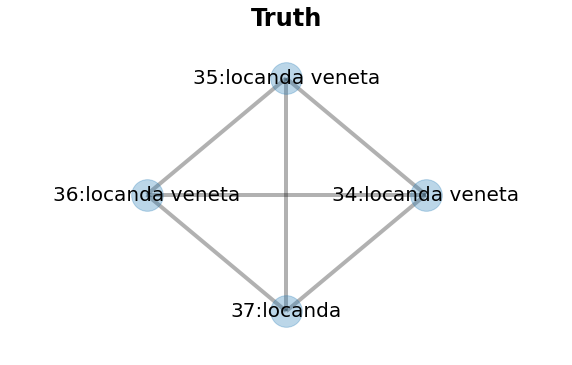

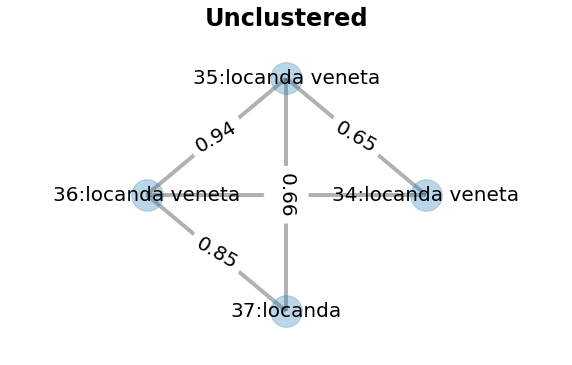

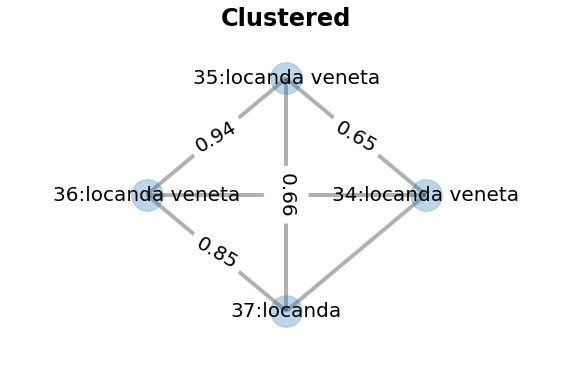

In [53]:
from graph_utils import show_cluster_graphs

diff_ids = {34, 35, 36, 37}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    dedupe_unclustered_pairs_score_dict,
    diff_ids)

## Next Steps

Make sure to learn about other pre-processing methods, indexing techniques, similarity functions, classifiers, etc. Check the talk **The Art and Science of Data Matching** [1] and read the book **Data Matching** [2].

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it, and index new nonmatches.
  - Other approaches, check papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

Also worth checking the **Privacy** implications of Record Linkage:
- Christen, chapter 8 [2]
- [k-anonymity](https://desfontain.es/privacy/k-anonymity.html), [k-map](https://desfontain.es/privacy/k-map.html), [δ-presence](https://desfontain.es/privacy/delta-presence.html)
- [Why differential privacy is awesome](https://desfontain.es/privacy/differential-privacy-awesomeness.html)

## References

- **Referenced** by this talk:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), and Jonathan de Bruin [@J535D165](https://github.com/J535D165).